In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import matplotlib.image as mpimg
from pathlib import Path
import glob
import os
import copy

In [2]:
# Load Image from directory
def load_image():
    file_name = []
    file_path = []
    for file in glob.glob('./sample_images/*'):
        file_name.append(Path(file).stem)
        file_path.append(file)
    return file_name, file_path

In [3]:
# Show the original image and the respective histogram
def show_ori_image_hist (file_name, file_path):
    fig, axs = plt.subplots(8, 2, figsize = (10,20))
    img = []

    for i in range (len(file_name)):
        file = file_path[i]
        image = cv2.imread(file) 
        img.append(image)

        axs[i, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[i, 0].set_title(f'{file_name[i]}')
        axs[i, 0].axis('off')

        line_colour = ['b','g','r']

        for j in range (len(line_colour)):
            hist = cv2.calcHist([image],[j],None,[256],[0,256])
            axs[i,1].plot(hist,line_colour[j])
            axs[i,1].set_title('Histogram')
    
    return img

In [4]:
# Get image with different colour space
def get_img_color_space(img):
    img_bgr = []
    img_rgb = []
    img_lab = []
    img_hsv = []
    img_ycbcr = []

    for i in range(len(img)):
        image = img[i]

        # Colour channels from OpenCV: BGR
        img_bgr.append(image)

        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_rgb.append(image_rgb)

        # Convert BGR to LAB
        image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        img_lab.append(image_lab)

        # Convert BGR to HSV
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        img_hsv.append(image_hsv)
        
        # Convert BGR to YCbCr
        image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        img_ycbcr.append(image_ycbcr)

        plt.tight_layout()
    
    return img_bgr, img_rgb, img_lab, img_hsv, img_ycbcr

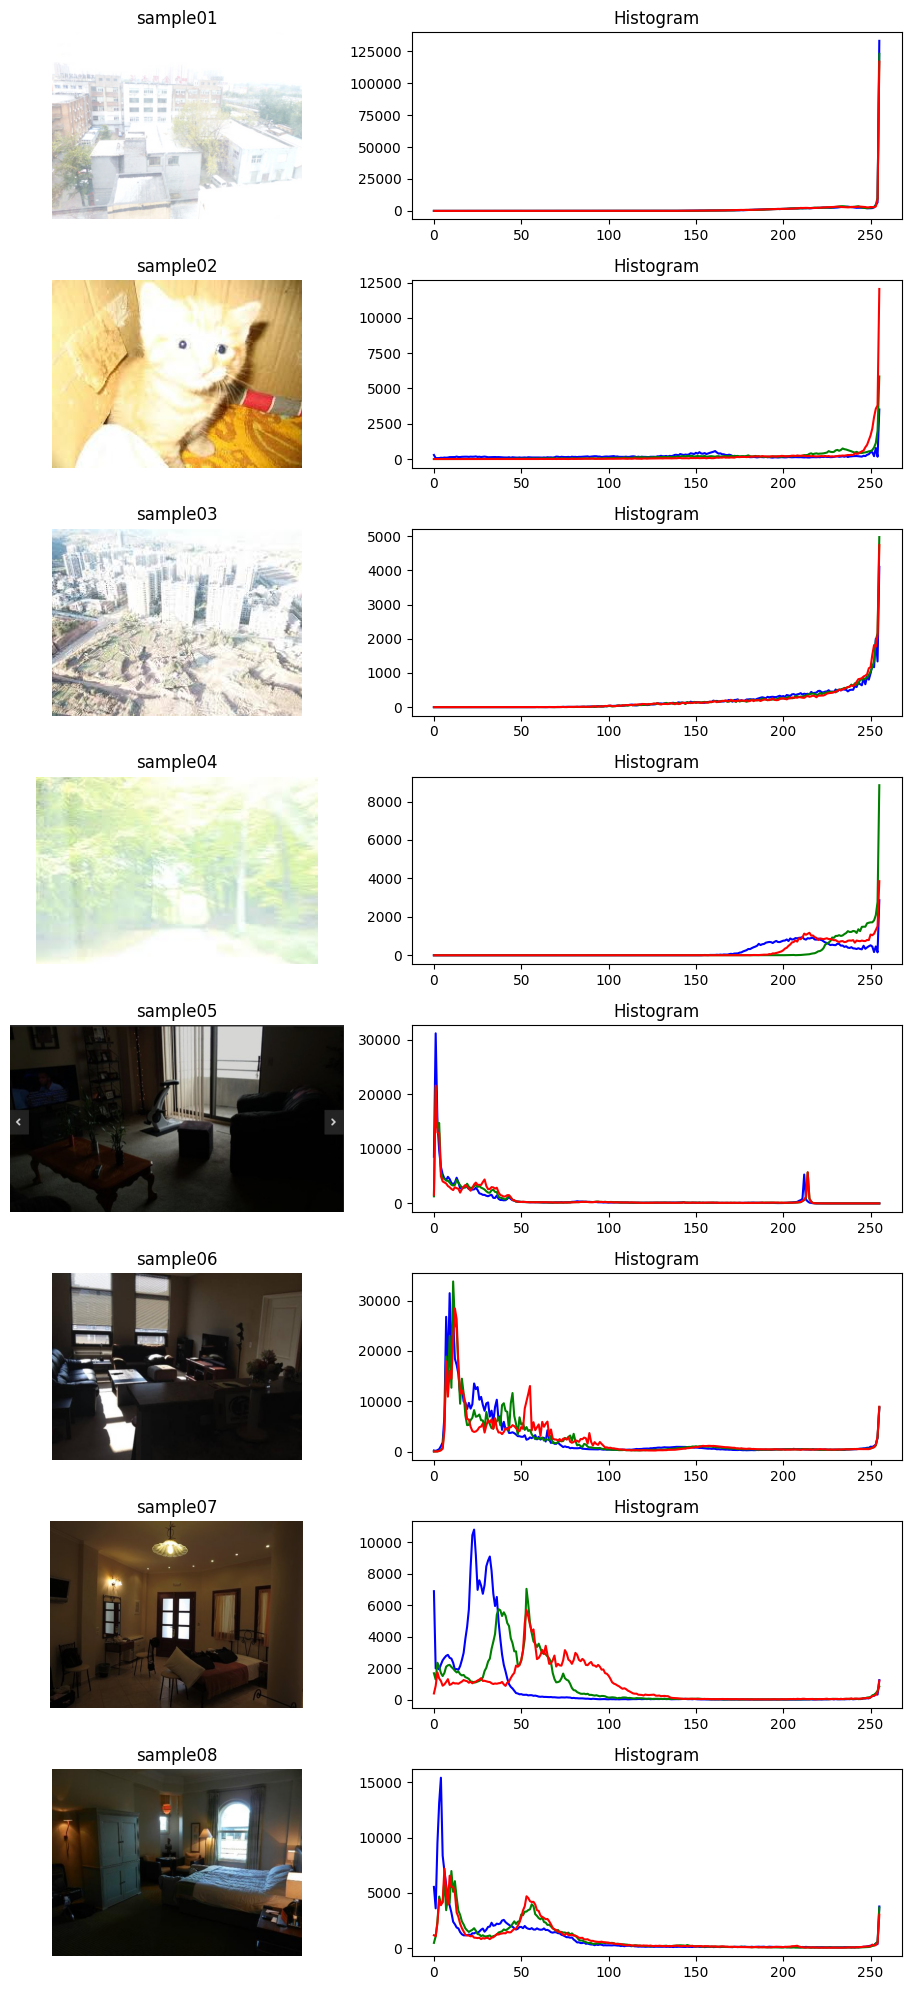

In [5]:
name, path = load_image()
img = show_ori_image_hist(name, path)
img_bgr, img_rgb, img_lab, img_hsv, img_ycbcr = get_img_color_space(img)

In [6]:
tri = [(img_lab, 0), (img_hsv, 2), (img_ycbcr, 0)]

# Display all output images in different colour space
def displayColorSpace(_tri, title):
    """
    _tri should be in order [origin, lab, hsv, ycbcr]
    """
    col = len(_tri[0])
    row = len(_tri)

    fig, axs = plt.subplots(row, col, figsize=(12, 6))
    for i in range(row):
        for j in range(col):
            if i == 1:
                temp = cv2.cvtColor(_tri[i][j], cv2.COLOR_LAB2RGB)
                axs[1,j].set_title('LAB')
            elif i == 2:
                temp = cv2.cvtColor(_tri[i][j], cv2.COLOR_HSV2RGB)
                axs[2,j].set_title('HSV')
            elif i == 3:
                temp = cv2.cvtColor(_tri[i][j], cv2.COLOR_YCrCb2RGB)
                axs[3,j].set_title('YCbCr')
            else:
                temp = _tri[i][j]
                axs[0,j].set_title('Original Image')
            plt.subplot(row, col, i*col+j+1)
            plt.imshow(temp)
            plt.axis('off')

    fig.suptitle(f'{title}')
    plt.tight_layout()
    plt.show()

Histogram Equalization

In [7]:
# Histogram equalization on a specific channel
def he(img):
    s = np.shape(img)
    img = np.reshape(img, s[0]*s[1])
    bins = range(257)
    bins = np.array(bins) - 0.5
    counts, bins = np.histogram(img, bins = bins)
    pdf = counts / counts.sum()
    cdf = np.zeros(256)
    for i in range(256):
        cdf[i] = cdf[max(0,i-1)] + pdf[i]
    cdf = cdf * 255
    cdf = np.round(cdf)
    return cdf

# Replace the specific channel with the equalized channel 
def apply(channel, normal):
    res = np.zeros(np.shape(channel))
    sh = np.shape(channel)
    for i in range(sh[0]):
        for j in range(sh[1]):
            res[i][j] = normal[channel[i][j]]
    return res

def resize(arr, shape):
    if arr.shape != shape:
        arr = cv2.resize(arr, (shape[0], shape[1]))
    return arr.astype(np.uint8)

# Histogram Equalization on image
def all_he(_imgs, channel=0):
    """
    Can use for all color space image list
    channel = 0/1/2 indicate the interested channel
    """
    _ress = copy.deepcopy(_imgs)

    for _img in _ress:
        
        _target = _img[:,:,channel]
        normalized = he(_target)
        _res = apply(_target, normalized)
        img_shape = _img.shape[:2]
        _res = resize(_res, img_shape)
        _img[:,:,channel] = _res
    return _ress

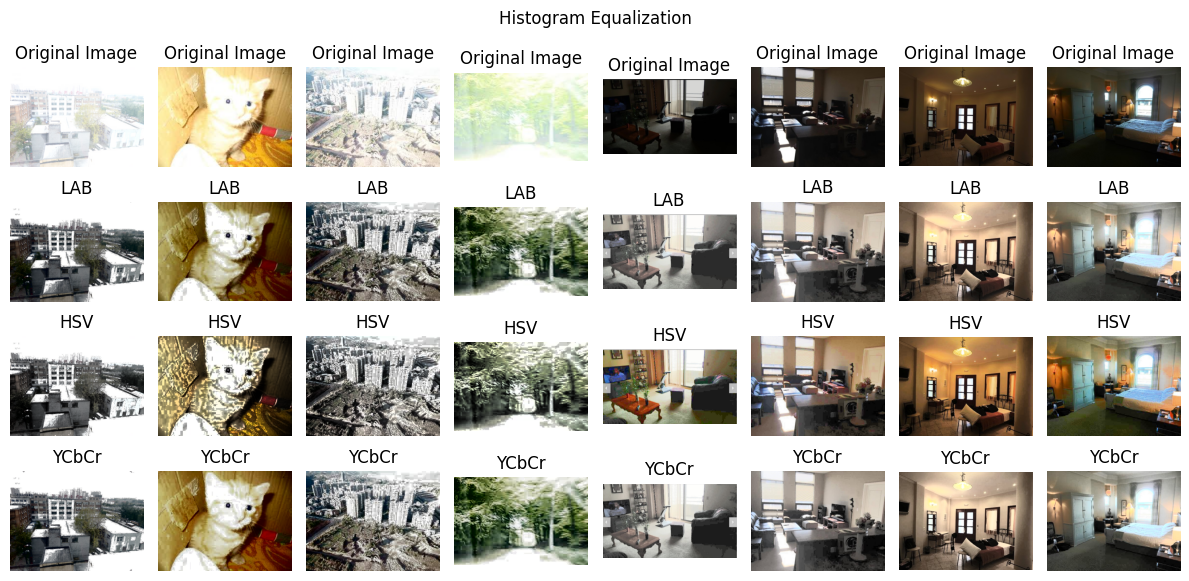

In [8]:
# Perform histogram equalization on images with three different colour space
lab_he_result = all_he(img_lab, 0)
hsv_he_result = all_he(img_hsv, 2)
ycbcr_he_result = all_he(img_ycbcr, 0)

# Display the original image and enhanced image
displayColorSpace([img_rgb, lab_he_result, hsv_he_result, ycbcr_he_result],'Histogram Equalization')

Prove that the Histogram Equalization algorithm is same as the cv2 function

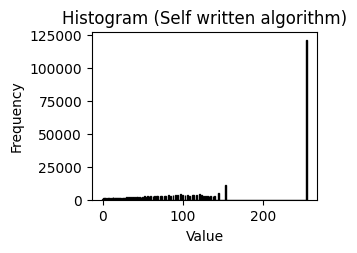

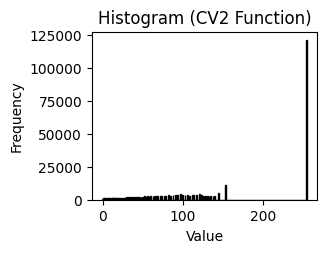

In [9]:
l,a,b = cv2.split(img_lab[0])


# Self written algorithm
normalized_l = he(l)
res = apply(l, normalized_l)

# Show the normalised image
# plt.subplot(1,1,1)
plt.imshow(res, cmap='gray')
plt.title('L Channel')
plt.axis('off')

bins = range(257)
bins = np.array(bins) - 0.5

plt.subplot(2, 2, 1)
plt.hist(res.reshape(-1), bins=bins, color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram (Self written algorithm)')
plt.show()

CV2_normalized_l = cv2.equalizeHist(l)
plt.subplot(2, 2, 2)
plt.hist(CV2_normalized_l.reshape(-1), bins=bins, color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram (CV2 Function)')
plt.show()

(array([[  0.,   0.,   6., ...,  23.,   0.,  53.],
        [  0.,   0.,   5., ...,  19.,   0.,  45.],
        [  0.,   0.,   4., ...,  46.,   0.,  34.],
        ...,
        [137.,  50.,   3., ...,   0.,   0.,   2.],
        [143.,  42.,   6., ...,   1.,   0.,   0.],
        [140.,  49.,   5., ...,   0.,   0.,   0.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 259 BarContainer objects>)

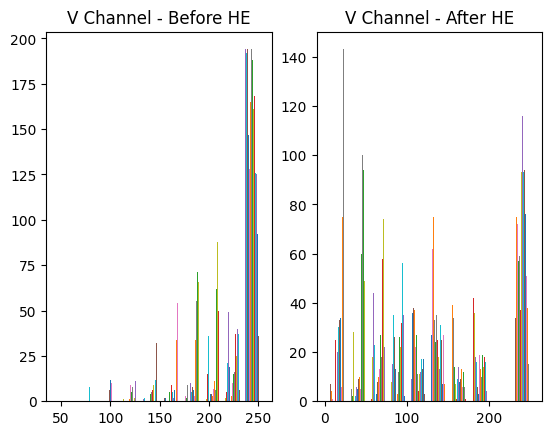

In [10]:
# Compare the V Channel before and after Histogram Equalization
test_02_before = img_hsv[1]
h,s,v = cv2.split(test_02_before)
plt.subplot(1,2,1)
plt.title('V Channel - Before HE')
plt.hist(v)

test_02_after = hsv_he_result[1]
_h,_s,_v = cv2.split(test_02_after)
plt.subplot(1,2,2)
plt.title('V Channel - After HE')
plt.hist(_v)

**Improvement of basic HE algorithm**

Local Histogram Equalization

In [11]:
def ahe(_img, _kernel_size=(16,16)):
    shape = _img.shape
    h = math.ceil(shape[0]/_kernel_size[0])
    w = math.ceil(shape[1]/_kernel_size[1])
    _res = np.zeros(shape, dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            _l, _a, _b = lab_he(_img[i*_kernel_size[0]:min((i+1)*_kernel_size[0], shape[0]), j*_kernel_size[1]:min((j+1)*_kernel_size[1], shape[1]), :])
            _res[i*_kernel_size[0]:min((i+1)*_kernel_size[0], shape[0]), j*_kernel_size[1]:min((j+1)*_kernel_size[1], shape[1]), :] = cv2.merge([_l, _a, _b])
    return _res

def all_ahe(_img, channel, _kernel_size=(16,16)):
    shape = _img.shape
    h = math.ceil(shape[0]/_kernel_size[0])
    w = math.ceil(shape[1]/_kernel_size[1])
    _res = np.zeros(shape, dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            temp = all_he([_img[i*_kernel_size[0]:min((i+1)*_kernel_size[0], shape[0]), j*_kernel_size[1]:min((j+1)*_kernel_size[1], shape[1]), :]], channel)
            _res[i*_kernel_size[0]:min((i+1)*_kernel_size[0], shape[0]), j*_kernel_size[1]:min((j+1)*_kernel_size[1], shape[1]), :] = temp[0]
    return _res

def aheForList(_imgs, channel=0, _kernel_size=(64,64)):
    _res = list()
    for _img in _imgs:
        _res.append(all_ahe(_img, channel, _kernel_size)) 
    return _res

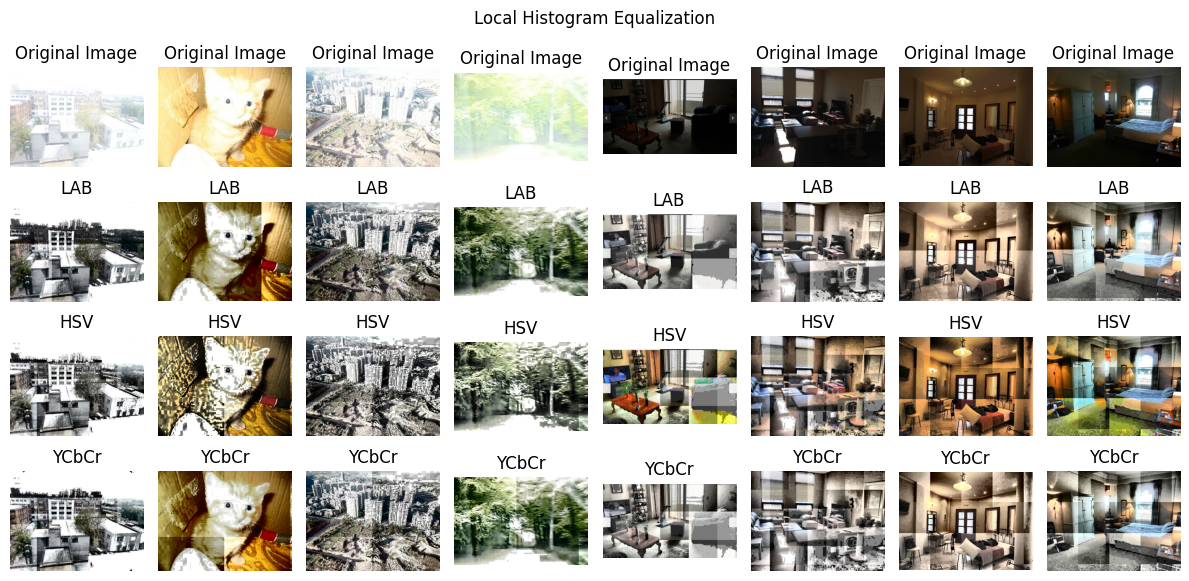

In [13]:
lab_ahe_result = aheForList(img_lab, 0, (200, 200))
hsv_ahe_result = aheForList(img_hsv, 2, (128, 128))
ycbcr_ahe_result = aheForList(img_ycbcr, 0, (128, 128))
displayColorSpace([img_rgb, lab_ahe_result, hsv_ahe_result, ycbcr_ahe_result],'Local Histogram Equalization')

Convolution Local Histogram Equalization

In [14]:
def conv_ahe(_img, _kernel_size=(16,16)):
    shape = _img.shape
    count = np.zeros(shape)
    _res = np.zeros(shape)
    h = shape[0] - _kernel_size[0] + 1
    w = shape[1] - _kernel_size[1] + 1
    for i in tqdm(range(h)):
        for j in range(w):
            _l, _a, _b = lab_he(_img[i:i + _kernel_size[0], j:j + _kernel_size[1], :])
            _res[i:i + _kernel_size[0], j:j + _kernel_size[1], :] += cv2.merge([_l, _a, _b])
            count[i:i + _kernel_size[0], j:j + _kernel_size[1], :] += 1
    _res = _res/count
    return _res.astype(np.uint8)

def all_conv_ahe(_img, channel=0, _kernel_size=(64,64)):
    shape = _img.shape
    count = np.zeros(shape)
    _res = np.zeros(shape)
    h = shape[0] - _kernel_size[0] + 1
    w = shape[1] - _kernel_size[1] + 1
    for i in tqdm(range(h)):
        for j in range(w):
            temp = all_he([_img[i:i + _kernel_size[0], j:j + _kernel_size[1], :]], channel)
            _res[i:i + _kernel_size[0], j:j + _kernel_size[1], :] += temp[0]
            count[i:i + _kernel_size[0], j:j + _kernel_size[1], :] += 1
    _res = _res/count
    return _res.astype(np.uint8)

def conv_aheForList(_imgs, channel=0, _kernel_size=(64,64)):
    _res = list()
    for _img in _imgs:
        _res.append(all_conv_ahe(_img, channel, _kernel_size)) 
    return _res

In [45]:
conv_ahe_img = conv_aheForList([copy.deepcopy(img_lab[5])], 0, (64,64))[0]
conv_ahe_img = cv2.cvtColor(conv_ahe_img, cv2.COLOR_LAB2BGR)
conv_ahe_img = cv2.cvtColor(conv_ahe_img, cv2.COLOR_BGR2RGB)

 40%|████      | 251/620 [17:19<25:27,  4.14s/it]


KeyboardInterrupt: 

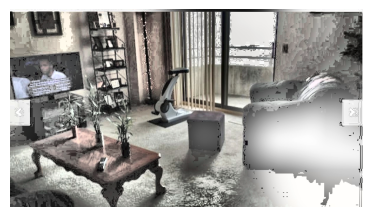

In [44]:
def display(images, names):
    no = len(images)
    row = math.ceil(no/2)
    plt.figure(figsize=(10, 6))
    for i in range(no):
        plt.subplot(row, 2, i+1)
        plt.imshow(images[i])
        if not len(name):
            plt.title(names[i])
        plt.axis('off')

display([conv_ahe_img], [])

# plt.imshow(conv_ahe_img)

In [23]:
# As the function code will expect a long time to execute for all sample images, we only show the outcome with a single sample image in the cell above.
# The enhanced image for all the 8 sample images are attached in the report appendix.

# lab_conv_result = conv_aheForList(img_lab, 0)
# hsv_conv_result = conv_aheForList(img_hsv, 2)
# ycbcr_conv_result = conv_aheForList(img_ycbcr, 0)
# displayColorSpace([img_rgb, lab_conv_result, hsv_conv_result, ycbcr_conv_result])

Interpolated Local Histogram Equalization

In [16]:
def searchForSmallerNearestCenter(index, kernel_size, img_len):
    idx = index
    while idx >= 0:
        if (idx-math.floor(kernel_size/2))%kernel_size == 0:
            return idx
        else:
            idx = idx - 1
    return math.floor(kernel_size/2)

def searchForLargerNearestCenter(index, kernel_size, img_len):
    idx = index
    while idx < img_len:
        if (idx-math.floor(kernel_size/2))%kernel_size == 0:
            return idx
        else:
            idx = idx + 1
    return img_len - 1 - math.floor(kernel_size/2)

def searchForCorePoints(i, j, kernel, img_size):
    center = math.floor(kernel[0]/2)
    #Core points
    if ( ((i-center)%kernel[0] == 0) and ((j-center)%kernel[1] == 0) ):
        return np.array([[i, j]])
    #Edges & Corner
    if i <= center or j <= center or i >= img_size[0]-1-center or j >= img_size[1]-1-center:
        #Corners (1 points)
        if (i < center and j < center):
            return np.array([[center, center]])
        elif (i < center and j > img_size[1]-1-center):
            return np.array([[center, img_size[1] - 1 - center]])
        elif (i > img_size[0]-1-center and j < center):
            return np.array([[img_size[0]-1-center, center]])
        elif (i > img_size[0]-1-center and j >= img_size[1]-1-center):
            return np.array([[img_size[0]-1-center, img_size[1]-1-center]])
        else: #Not corners (2 points)
            if i <= center:
                ay = searchForSmallerNearestCenter(j, kernel[1], img_size[1])
                by = searchForLargerNearestCenter(j, kernel[1], img_size[1])
                ax = center
                bx = center
                if ay == by:
                    ax = bx = searchForLargerNearestCenter(i, kernel[0], img_size[0])
            elif j <= center:
                ax = searchForSmallerNearestCenter(i, kernel[0], img_size[0])
                bx = searchForLargerNearestCenter(i, kernel[0], img_size[0])
                ay = center
                by = center
                if ax == bx:
                    ay = by = searchForLargerNearestCenter(j, kernel[1], img_size[1])
            elif i >= img_size[0]-1-center:
                ay = searchForSmallerNearestCenter(j, kernel[1], img_size[1])
                by = searchForLargerNearestCenter(j, kernel[1], img_size[1])
                ax = img_size[0]-1-center
                bx = img_size[0]-1-center
                if ay == by:
                    ax = bx = searchForSmallerNearestCenter(i, kernel[0], img_size[0])
            elif j >= img_size[1]-1-center:
                ax = searchForSmallerNearestCenter(i, kernel[0], img_size[0])
                bx = searchForLargerNearestCenter(i, kernel[0], img_size[0])
                ay = img_size[1]-1-center
                by = img_size[1]-1-center
                if ax == bx:
                    ay = by = searchForSmallerNearestCenter(j, kernel[1], img_size[1])
            return np.array([[ax, ay], [bx, by]])
    #Body (4 points)
    else:
        minx = searchForSmallerNearestCenter(i, kernel[0], img_size[0])
        miny = searchForSmallerNearestCenter(j, kernel[1], img_size[1])
        maxx = searchForLargerNearestCenter(i, kernel[0], img_size[0])
        maxy = searchForLargerNearestCenter(j, kernel[1], img_size[1])
        return np.array([[minx, miny], [minx, maxy], [maxx, miny], [maxx, maxy]])

def interpolate(_a, _b, av, bv, t):
    # print(_a, _b, av, bv, t)
    return round(min(255 ,math.ceil(av*(_b-t)/(_b-_a) + bv*(t-_a)/(_b-_a))))

def interpolation(_img, kernel=(9,9), channel=0):
    center = math.floor(kernel[0]/2)
    h = math.ceil(_img.shape[0]/kernel[0])
    w = math.ceil(_img.shape[1]/kernel[1])
    for i in range(_img.shape[0]):
        for j in range(_img.shape[1]):
            pts = searchForCorePoints(i, j, kernel, _img.shape[:-1])
            # print(pts)
            if len(pts) == 1:
                continue
            elif len(pts) == 2:
                if pts[0, 0] == pts[1,0] and pts[0,1] == pts[1,1]:
                    _img[i][j][channel] = _img[pts[0,0], pts[0,1], channel]
                # have same x coor
                elif pts[0, 0] == pts[1,0]:
                    _img[i][j] = interpolate(pts[0,1], pts[1,1], _img[pts[0, 0], pts[0,1], channel], _img[pts[1, 0], pts[1,1], channel], j)
                else:# same y coor
                    _img[i][j] = interpolate(pts[0,0], pts[1,0], _img[pts[0, 0], pts[0,1], channel], _img[pts[1, 0], pts[1,1], channel], i)
            else:
                # On vertical edges
                if pts[0, 0] == pts[1,0] and pts[0,1] == pts[1,1]:
                    _img[i][j] = interpolate(pts[0,0], pts[2,0], _img[pts[0, 0], pts[0,1], channel], _img[pts[2, 0], pts[2,1], channel], i)
                # On horizontal edges
                elif pts[0, 0] == pts[2,0] and pts[0,1] == pts[2,1]:
                    _img[i][j] = interpolate(pts[0,1], pts[1,1], _img[pts[0, 0], pts[0,1], channel], _img[pts[1, 0], pts[1,1], channel], j)
                else:
                    temp_a = interpolate(pts[0,1], pts[1,1], _img[pts[0, 0], pts[0,1], channel], _img[pts[1, 0], pts[1,1], channel], j)
                    temp_b = interpolate(pts[2,1], pts[3,1], _img[pts[2, 0], pts[2,1], channel], _img[pts[3, 0], pts[3,1], channel], j)
                    _img[i][j] = interpolate(pts[0,0], pts[2,0], temp_a, temp_b, i)
    return _img


def interpol_ahe(_img, channel, _kernel_size=(9,9)):
    shape = list(_img.shape)
    center = math.floor(_kernel_size[0]/2)
    shape[0] = (shape[0]//_kernel_size[0])*_kernel_size[0]
    shape[1] = (shape[1]//_kernel_size[1])*_kernel_size[1]
    h = math.ceil(shape[0]/_kernel_size[0])
    w = math.ceil(shape[1]/_kernel_size[1])
    _res = np.zeros(shape, dtype=np.uint8)

    cp = _img.copy()
    cp = cp[:shape[0], :shape[1], :]
    for i in range(h):
        for j in range(w):
            temp = all_he([cp[i*_kernel_size[0]:min((i+1)*_kernel_size[0], shape[0]), j*_kernel_size[1]:min((j+1)*_kernel_size[1], shape[1]), :]], channel)
            _res[i*_kernel_size[0] + center, j*_kernel_size[1] + center, :] = temp[0][center, center, :]

    ans = interpolation(_res, _kernel_size)
    cp = _img.copy()
    cp = cp[:shape[0], :shape[1], :]
    cp[:, :, channel] = ans[:, :, channel]
    return cp

def interpol_aheForList(_imgs, channel=0, _kernel_size=(9,9)):
    _res = list()
    for _img in _imgs:
        cp = _img.copy()
        _res.append(interpol_ahe(cp, channel))
    return _res

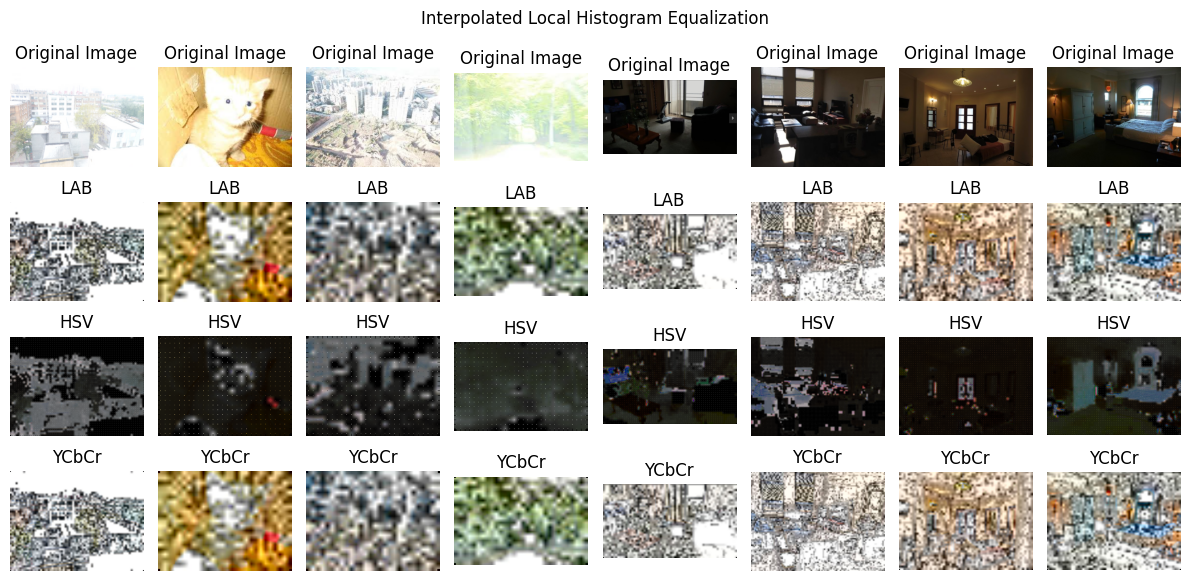

In [17]:
inter_lab_result = interpol_aheForList(img_lab,0)
inter_hsv_result = interpol_aheForList(img_hsv,2)
inter_ycbcr_result = interpol_aheForList(img_ycbcr,0)
displayColorSpace([img_rgb,inter_lab_result,inter_hsv_result,inter_ycbcr_result],'Interpolated Local Histogram Equalization')

Cross Histogram Equalization

In [18]:
def weighted_sum(_origin, _processed, channel=0, ratio=0.5):
    _l = _origin[:,:,channel]
    _L = _processed[:,:,channel]
    ll = (_l*(1-ratio) + _L*ratio)
    ll = ll.astype(np.uint8)
    _res = _origin.copy()
    _res[:,:, channel] = ll
    _res = _res.astype(np.uint8)
    return _res

def weighted_sumList(_origin_list, _processed_list, channel=0, ratio=0.5):
    _res = list()
    for i in range(len(_origin_list)):
        _res.append(weighted_sum(_origin_list[i], _processed_list[i], channel, ratio)) 
    return _res

def horizontal_he(_img, channel=0):
    shape = _img.shape
    count = np.zeros(shape)
    _res = np.zeros(shape)
    for i in tqdm(range(shape[0])):
        temp = all_he([np.reshape(_img[i], (1,shape[1],3))], channel)
        _res[i, :, :] += temp[0][0]
    return _res.astype(np.uint8)

def horizontal_heForList(_imgs, channel=0):
    _res = list()
    for _img in _imgs:
        _res.append(horizontal_he(_img, channel))
    return _res

def vertical_he(_img, channel=0):
    shape = _img.shape
    _res = np.zeros(shape)
    for j in tqdm(range(shape[1])):
        n = np.reshape(_img[:,j, :], (shape[0], 1, 3))
        temp = all_he([n], channel)
        _res[:, j, :] += np.reshape(temp[0], (shape[0], 3))
    return _res.astype(np.uint8)

def vertical_heForList(_imgs, channel=0):
    _res = list()
    for _img in _imgs:
        _res.append(vertical_he(_img, channel))
    return _res

100%|██████████| 550/550 [00:00<00:00, 801.77it/s]


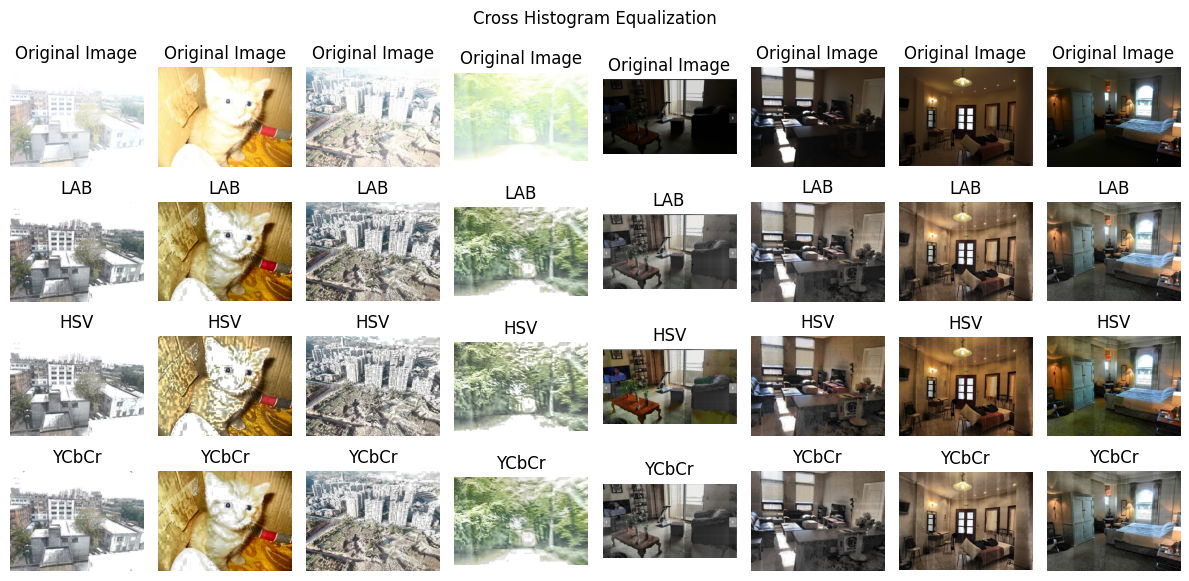

In [28]:
lab_hhe_result = horizontal_heForList(img_lab,0)
lab_vhe_result = vertical_heForList(img_lab,0)

hsv_hhe_result = horizontal_heForList(img_hsv,2)
hsv_vhe_result = vertical_heForList(img_hsv,2)

ycbcr_hhe_result = horizontal_heForList(img_ycbcr,0)
ycbcr_vhe_result = vertical_heForList(img_ycbcr,0)

cross_he_lab_result = weighted_sumList(lab_hhe_result, lab_vhe_result,0,0.6)
cross_he_hsv_result = weighted_sumList(hsv_hhe_result, hsv_vhe_result,2,0.6)
cross_he_ycbcr_result = weighted_sumList(ycbcr_hhe_result, ycbcr_vhe_result,0,0.6)

cross_lab_ws_result = weighted_sumList(img_lab, cross_he_lab_result,0,0.6)
cross_hsv_ws_result = weighted_sumList(img_hsv, cross_he_hsv_result,2,0.6)
cross_ycbcr_ws_result = weighted_sumList(img_ycbcr, cross_he_ycbcr_result,0,0.6)
displayColorSpace([img_rgb, cross_lab_ws_result, cross_hsv_ws_result, cross_ycbcr_ws_result],'Cross Histogram Equalization')

Comparison of Image Histogram with different Histogram Equalization algorithm

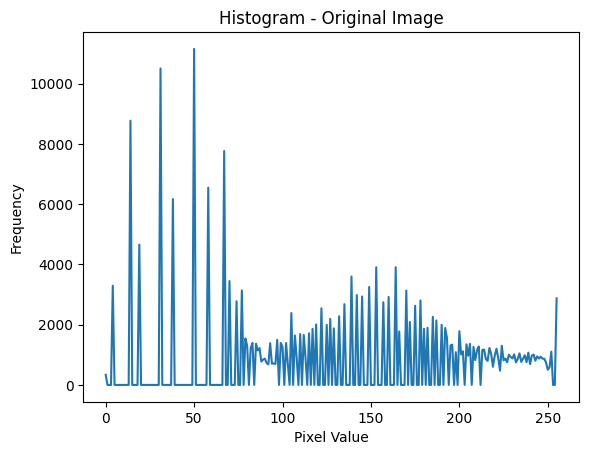

Mean: 129.42427625772285 Std: 72.318840854411


In [31]:
histogram = cv2.calcHist([lab_he_result[7][:,:,0]], [0], None, [256], [0, 256])
plt.plot(histogram)
plt.title("Histogram - Original Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()
print("Mean:", np.mean(lab_he_result[7][:,:,0]), "Std:",  np.std(lab_he_result[7][:,:,0]))

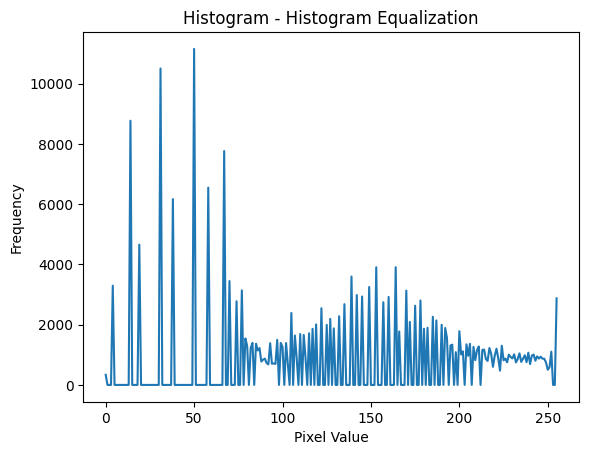

Mean: 129.42427625772285 Std: 72.318840854411


In [32]:
histogram = cv2.calcHist([lab_he_result[7][:,:,0]], [0], None, [256], [0, 256])
plt.plot(histogram)
plt.title("Histogram - Histogram Equalization")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()
print("Mean:", np.mean(lab_he_result[7][:,:,0]), "Std:",  np.std(lab_he_result[7][:,:,0]))

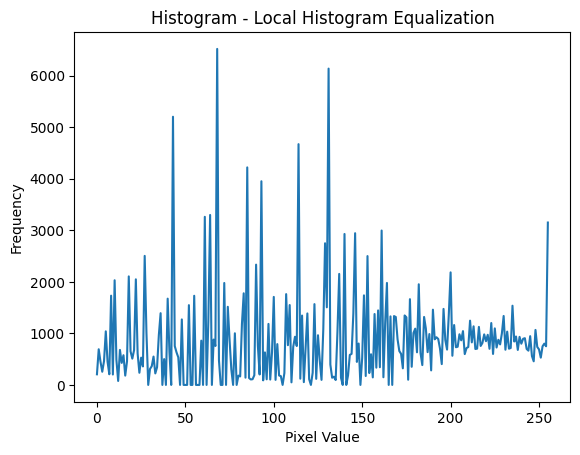

Mean: 132.4397440423654 Std: 71.55084938663278


In [33]:
histogram = cv2.calcHist([lab_ahe_result[7][:,:,0]], [0], None, [256], [0, 256])
plt.plot(histogram)
plt.title("Histogram - Local Histogram Equalization")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()
print("Mean:", np.mean(lab_ahe_result[7][:,:,0]), "Std:",  np.std(lab_ahe_result[7][:,:,0]))

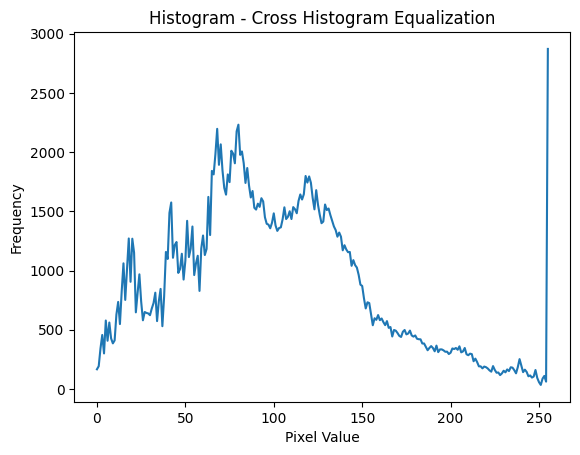

Mean: 101.25733451015005 Std: 54.382678742186236


In [43]:
histogram = cv2.calcHist([cross_lab_ws_result[7][:,:,0]], [0], None, [256], [0, 256])
plt.plot(histogram)
plt.title("Histogram - Cross Histogram Equalization")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()
print("Mean:", np.mean(cross_lab_ws_result[7][:,:,0]), "Std:",  np.std(cross_lab_ws_result[7][:,:,0]))

Contrast Limited Adaptive Histogram Equalization (CLAHE)

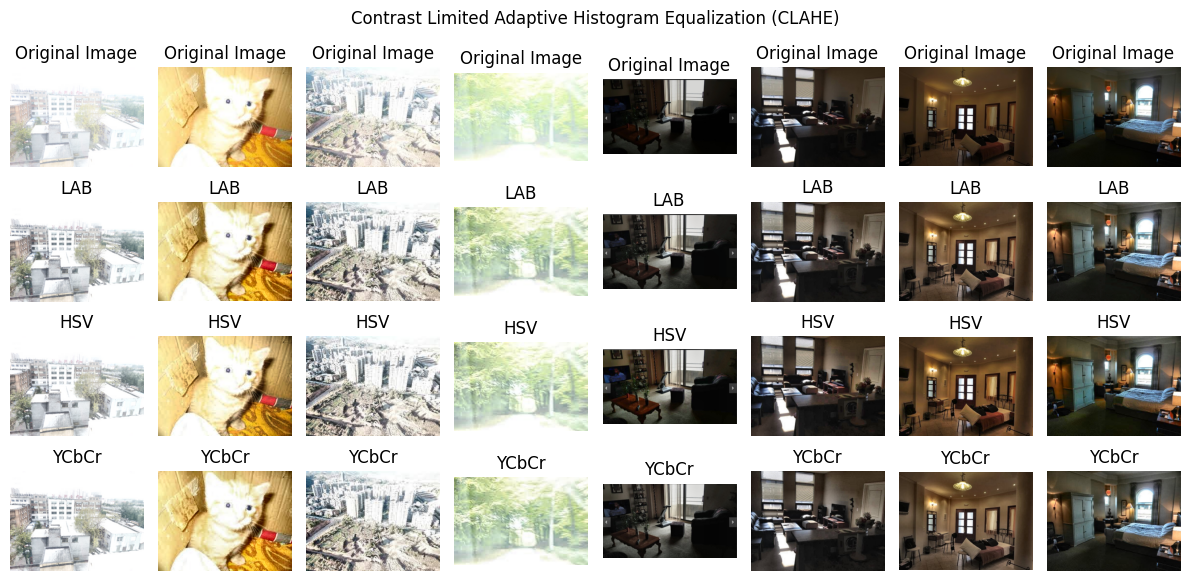

In [ ]:

def clahe(_img, channel):
    clahe_img = []

    for i in range (len(_img)):
        image = _img[i]
        color_channel = list(cv2.split(image))

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_channel = clahe.apply(color_channel[channel])
        color_channel[channel] = clahe_channel
        clahe_img.append(cv2.merge(color_channel))


    return clahe_img

clahe_lab_output = clahe(img_lab,0)
clahe_hsv_output = clahe(img_hsv,2)
clahe_ycbcr_output = clahe(img_ycbcr,0)
displayColorSpace([img_rgb,clahe_lab_output, clahe_hsv_output, clahe_ycbcr_output],'Contrast Limited Adaptive Histogram Equalization (CLAHE)')